# KL Divergence - Dywergencja

Kullback-Leibler divergence.
Distance metric that quantifies the difference between two probability distributions.
One common scenario where this is useful is when we are working with a complec distribution.
Rather than working with distribution with well known properties (i.e. normal distribution) that does a decent job of descripting the data.

We an use the KL divergence to tell whether a poisson distribution or a normal distribution is a better at approximating the data.
The KL divergence is also a key component od Gaussian Mixture Models an t-SNE.

P, Q - continous random variable
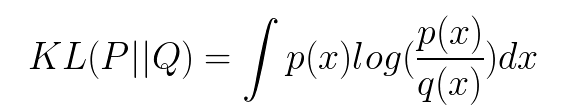

if P and Q represent the probability distribution of a dicrete random variable, the Kullback-Leibler divergence is calculated as a summation.
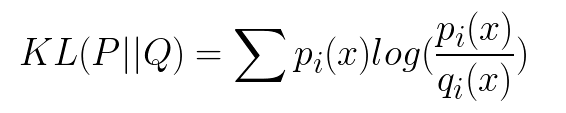

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns

sns.set()

A function to calculate the KL divergence of two prbability distribution.
We need to make sure that we don't include any probabilities equal to 0.

BEAUSE THE LOG OF 0 IS NEGATIVE INFINITY.
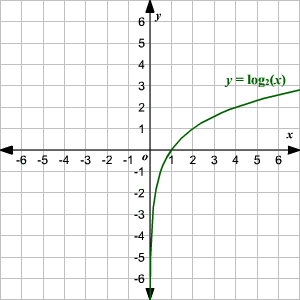

In [2]:
def kl_divergence(p, q):
    nums = np.where(p != 0, p * np.log(p / q), 0)
    return np.sum(nums)

The KL divergence between a normal distribution with a mean of 0 and a standard deviation of 2 and another distribution with a men of 2 and a standard deviation of 2 is equal to 500.

In [5]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 2, 2)

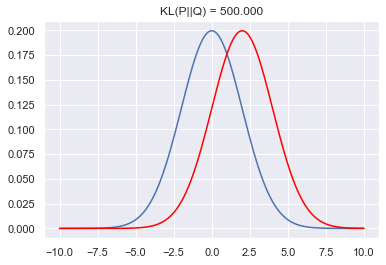

In [11]:
plt.title("KL(P||Q) = %1.3f"%kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c="red")
plt.show()

If we measure the KL divergence between the initial probability distribution and another distribution with a mean of 5 and a standard deviation of 4, we expect the KL divergence to be higher than in the previous example.

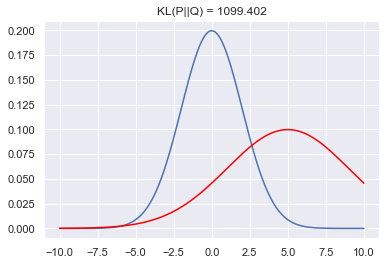

In [16]:
q = norm.pdf(x, 5, 4)

plt.title("KL(P||Q) = %1.3f"%kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c="red")
plt.show()

It's important to note that KL divergence is not symmetrical.

If we switch P for Q and vice versa, we get a different result.

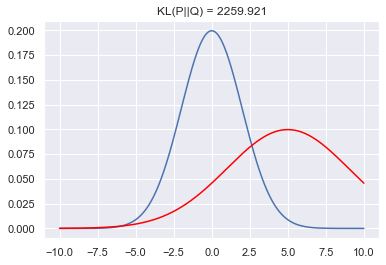

In [17]:
plt.title("KL(P||Q) = %1.3f"%kl_divergence(q, p))
plt.plot(x, p)
plt.plot(x, q, c="red")
plt.show()

The lower the KL divergence, the closer the two distributions are to one another.

Therefore, as in the case of t-SNE and Gaussian Mixture Models, we  can estimate the gaussian parameters of one distribution by minimizing its KL divergence with respect to another.

## Minimizing KL Divergence

Let's use gradient descent for minimizing the KL divergence between two probability distributions using gradient descent.

We create a probability distribution with a known mean (0) and variance (2).

Now let's create another distribution with random parameters.

In [26]:
x = np.arange(-10, 10, 0.001)
p_pdf = norm.pdf(x, 0, 2).reshape(1, -1)

In [27]:
np.random.seed(0)

In [28]:
random_mean = np.random.randint(10, size=1)
random_sigma = np.random.randint(10, size=1)
random_pdf = norm.pdf(x, random_mean, random_sigma).reshape(1, -1)

Seleting hyperparameters (step size, number of iterations, etc).

In [29]:
learning_rate = 0.001
epochs = 100

Just like numpy, in tensorfow we need to allocate memory for variables.

For the variable `q`, we use the equation for a normal distribution given mu and sigma, only we exclude the part before the exponent since we're normalizing the result.
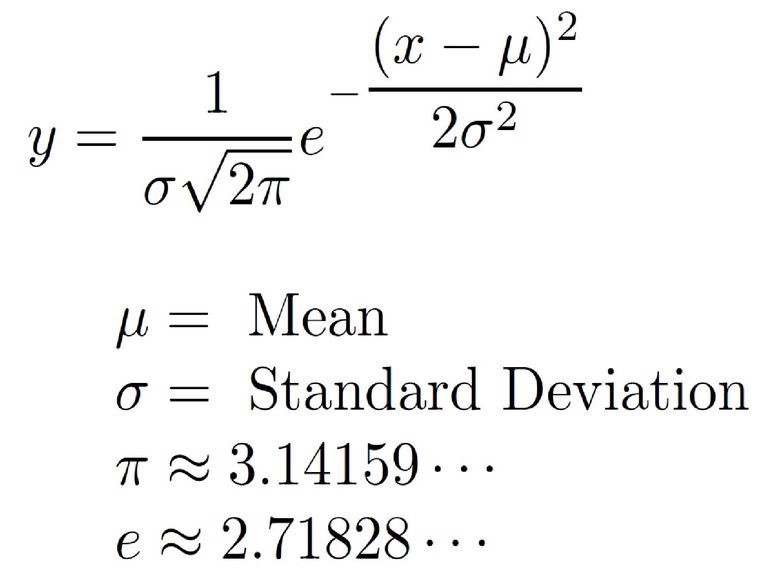

In [30]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [35]:
p = tf.placeholder(tf.float64, shape=random_pdf.shape)
mu = tf.Variable(np.zeros(1))
sigma = tf.Variable(np.eye(1))
normal = tf.exp(-tf.square(x-mu) / (2 * sigma))
q = normal / tf.reduce_sum(normal)

Define a function to compute the KL divergence that excludes probabilities equal to zero.

In [36]:
kl_divergence = tf.reduce_sum(
    tf.where(p == 0, tf.zeros(random_pdf.shape, tf.float64), p * tf.log(p / q))
)

In [38]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(kl_divergence)

Only after running `tf.global_variables_initializer()` will the variables hold the values we set when we declared them (f.e. `tf.zeros`).

In [39]:
init = tf.global_variables_initializer()

All operations in tensorflow must be done within a session.

In the proceeding codeblock we minimize the KL divergence using gradient descent.

R:\Work\Anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
R:\Work\Anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
R:\Work\Anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
R:\Work\Anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)
R:\Work\Anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
R:\Work\Anacond\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  ret

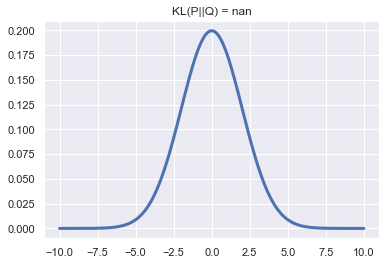

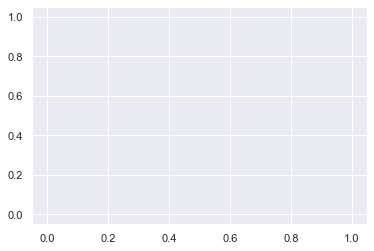

In [42]:
with tf.Session() as sess:
    sess.run(init)
    
    history, means, variances = [], [], []
    
    for i in range(epochs):
        sess.run(optimizer, {p:random_pdf})
        
        if i % 10 == 0:
            history.append(sess.run(kl_divergence, {p:random_pdf}))
            means.append(sess.run(mu)[0])
            variances.append(sess.run(sigma)[0][0])
    
    for mean, variance in zip(means, variances):
        q_pdf = norm.pdf(x, mean, np.sqrt(variance))
        plt.plot(x, q_pdf.reshape(-1, 1), c="red")
plt.title("KL(P||Q) = %1.3f"% history[-1])
plt.plot(x, p_pdf.reshape(-1, 1), linewidth=3)
plt.show()

plt.plot(history)
plt.show()

sess.close()